# setup

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy import io
import pandas as pd

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def lara_graph(X):
    D = distance_matrix(X, X) ** 2
    D[np.diag_indices(D.shape[0])] = 1e6

    n = X.shape[0]
    adjacencia = np.zeros(shape = (n, n))
    for i in range(n-1):
        for j in range(i+1, n):
            minimo = min(D[i, :] + D[j, :])
            if (D[i, j] <= minimo):
                adjacencia[i, j] = 1
                adjacencia[j, i] = 1
    return adjacencia

In [ ]:
def q_index(X, y, gg):
    scores = []
    for i, row in enumerate(gg):
        vizinhos = np.where(row == 1)[0]
        
        degree = len(vizinhos)
        opposite = 0
        for vizinho in vizinhos:
            opposite += np.exp(-np.linalg.norm(X[i] - X[vizinho])) * np.abs(y[i] - y[vizinho]) / 2
        q = 1 - opposite / degree
        scores.append(q)
    scores = np.array(scores)
    return scores

In [ ]:
dir_path = 'drive/MyDrive/data/benchmark'
datasets = ('australian', 
            'banknote', 
            'breastcancer', 
            'breastHess', 
            'bupa', 
            'climate', 
            'diabetes', 
            'fertility', 
            'german', 
            'golub', 
            'haberman', 
            'heart', 
            'ILPD', 
            'parkinsons', 
            'sonar')
K = 10

# plot

1it [00:19, 19.36s/it]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
15it [04:32, 18.16s/it]


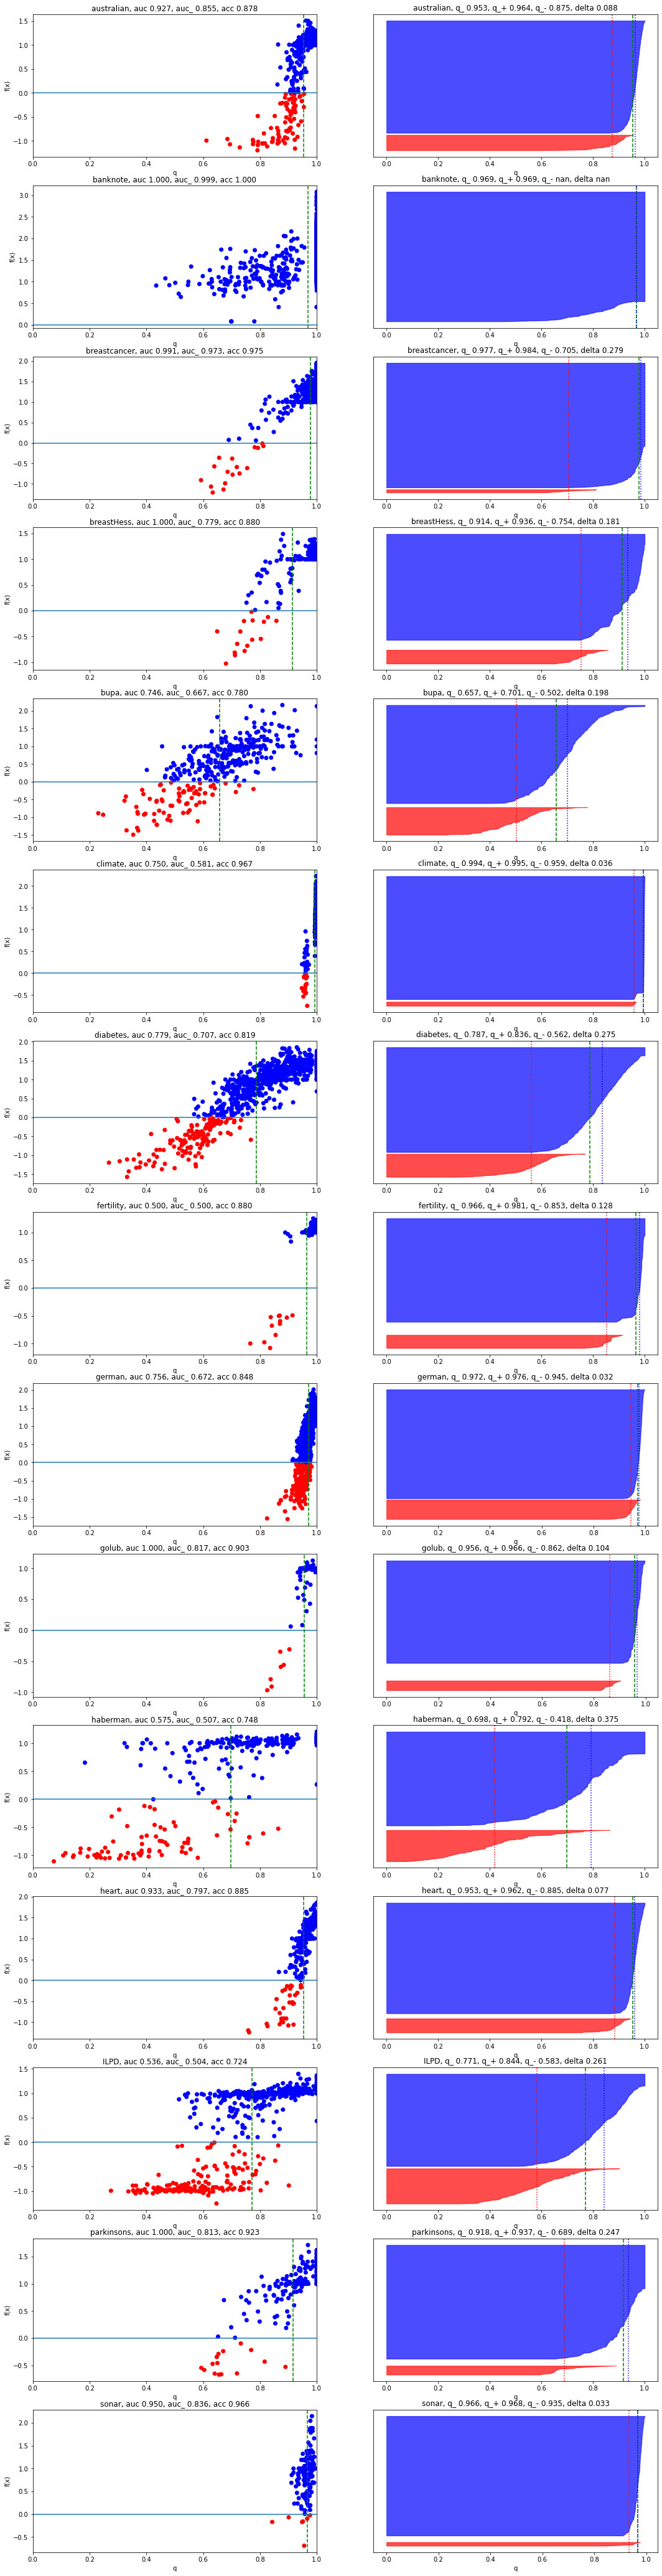

In [ ]:
fig, axis = plt.subplots(len(datasets), 2, figsize = (18, 5*len(datasets)))

for idx, dataset in tqdm(enumerate(datasets)):
  acuracia = []
  best = 0
  # k fold
  for fold_n in range(K):
    # read
    filename = '{}/exportBase_{}_folds_10_exec_{}.mat'.format(dir_path, dataset, fold_n + 1)
    data_mat = io.loadmat(filename)

    # train / test
    train = data_mat['data']['train'][0][0]
    classTrain = data_mat['data']['classTrain'][0][0].ravel()
    test = data_mat['data']['test'][0][0]
    classTest = data_mat['data']['classTest'][0][0].ravel()

    # model
    model = SVC()
    model.fit(train, classTrain)

    # eval
    acc = roc_auc_score(classTest, model.predict(test))
    acuracia.append(acc)

    if acc > best:
      best = acc
      clf = model
  
  # data
  X = np.concatenate((train, test), axis = 0)
  y = np.concatenate((classTrain, classTest), axis = 0)

  # gg
  gg = lara_graph(X)
  scores = q_index(X, y, gg)
  q_mean = np.mean(scores)

  # clc
  distances = clf.decision_function(X)
  distances[y == -1] *= -1
  yhat = clf.predict(X)
  erro = y != yhat

  auc_mean = np.mean(acuracia)
  eta = 1 - sum(erro) / len(erro)

  q_bom = np.mean(scores[~erro])
  q_ruim = np.mean(scores[erro])
  delta = q_bom - q_ruim

  # plot
  log = np.stack((scores, distances)).T
  colors = {0:'blue', 1:'red'}

  axis[idx, 0].scatter(log[:, 0], log[:, 1], c = [colors[e] for e in erro])
  axis[idx, 0].axhline(y = 0)
  axis[idx, 0].axvline(x = q_mean, color = 'green', linestyle = '--')
  axis[idx, 0].set_xlim([0, 1])
  axis[idx, 0].set_title('{}, auc {:.3f}, auc_ {:.3f}, acc {:.3f}'.format(dataset, best, auc_mean, eta));
  axis[idx, 0].set_xlabel('q')
  axis[idx, 0].set_ylabel('f(x)');

  y_lower = 10
  for c in [1, 0]:
      cluster = erro == c
      ith_cluster_silhouette_values = scores[cluster]
      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = colors[c]
      axis[idx, 1].fill_betweenx(
          np.arange(y_lower, y_upper),
          0,
          ith_cluster_silhouette_values,
          facecolor=color,
          edgecolor=color,
          alpha=0.7,
      )
      y_lower = y_upper + 10
  axis[idx, 1].axvline(x = q_mean, color = 'green', linestyle = '--')
  axis[idx, 1].axvline(x = q_bom, color = 'blue', linestyle = 'dotted')
  axis[idx, 1].axvline(x = q_ruim, color = 'red', linestyle = 'dotted')
  axis[idx, 1].set_yticks([])
  axis[idx, 1].set_title('{}, q_ {:.3f}, q_+ {:.3f}, q_- {:.3f}, delta {:.3f}'.format(dataset, q_mean, q_bom, q_ruim, delta));
  axis[idx, 1].set_xlabel('q')

# estatistica

## coleta

In [ ]:
fold_n = 0

dados = np.zeros(shape = (len(datasets), 3))
target = np.zeros(shape = (len(datasets), 1))

for idx, dataset in tqdm(enumerate(datasets)):
  # read
  filename = '{}/exportBase_{}_folds_10_exec_{}.mat'.format(dir_path, dataset, fold_n + 1)
  data_mat = io.loadmat(filename)

  # train / test
  train = data_mat['data']['train'][0][0]
  classTrain = data_mat['data']['classTrain'][0][0].ravel()
  test = data_mat['data']['test'][0][0]
  classTest = data_mat['data']['classTest'][0][0].ravel()

  # model
  model = SVC()
  model.fit(train, classTrain)

  # eval
  # acc = roc_auc_score(classTest, model.predict(test))
  
  # data
  X = np.concatenate((train, test), axis = 0)
  y = np.concatenate((classTrain, classTest), axis = 0)

  # gg
  gg = lara_graph(X)
  scores = q_index(X, y, gg)
  q_mean = np.mean(scores)

  # clc
  yhat = model.predict(X)
  erro = y != yhat
  acc = 1 - sum(erro) / len(erro)

  q_bom = np.mean(scores[~erro])
  q_ruim = np.mean(scores[erro])
  delta = q_bom - q_ruim

  # log
  dados[idx, 0] = q_mean
  dados[idx, 1] = q_bom
  dados[idx, 2] = q_ruim
  # dados[idx, 3] = delta # ?
  target[idx] = acc

1it [00:17, 17.98s/it]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
15it [04:27, 17.82s/it]


In [ ]:
print(dados)
print(target)

[[0.95284518 0.96339424 0.87353189]
 [0.96886558 0.96886558        nan]
 [0.97692567 0.9840398  0.69821918]
 [0.9137374  0.93542271 0.75516356]
 [0.65699536 0.70096264 0.49598007]
 [0.99354377 0.995068   0.95928171]
 [0.78659292 0.83861972 0.57045478]
 [0.96555764 0.98087446 0.85323427]
 [0.9715758  0.97618177 0.94526923]
 [0.95613138 0.96622308 0.86242277]
 [0.69823486 0.78864328 0.40440749]
 [0.95283953 0.96190353 0.88295897]
 [0.77149537 0.84420825 0.58905212]
 [0.91750209 0.93937123 0.68851944]
 [0.96643556 0.96755448 0.94639675]]
[[0.8826087 ]
 [1.        ]
 [0.97510981]
 [0.87969925]
 [0.78550725]
 [0.95740741]
 [0.80598958]
 [0.88      ]
 [0.851     ]
 [0.90277778]
 [0.76470588]
 [0.88518519]
 [0.71502591]
 [0.91282051]
 [0.94711538]]


### if nan

In [ ]:
# if nan
exclude = np.ones(len(dados), dtype = bool)
exclude[1] = False
dados = dados[exclude, :]
target = target[exclude, :]
print(dados)
print(target)

[[0.95284518 0.96339424 0.87353189]
 [0.97692567 0.9840398  0.69821918]
 [0.9137374  0.93542271 0.75516356]
 [0.65699536 0.70096264 0.49598007]
 [0.99354377 0.995068   0.95928171]
 [0.78659292 0.83861972 0.57045478]
 [0.96555764 0.98087446 0.85323427]
 [0.9715758  0.97618177 0.94526923]
 [0.95613138 0.96622308 0.86242277]
 [0.69823486 0.78864328 0.40440749]
 [0.95283953 0.96190353 0.88295897]
 [0.77149537 0.84420825 0.58905212]
 [0.91750209 0.93937123 0.68851944]
 [0.96643556 0.96755448 0.94639675]]
[[0.8826087 ]
 [0.97510981]
 [0.87969925]
 [0.78550725]
 [0.95740741]
 [0.80598958]
 [0.88      ]
 [0.851     ]
 [0.90277778]
 [0.76470588]
 [0.88518519]
 [0.71502591]
 [0.91282051]
 [0.94711538]]


## regressao

In [ ]:
import statsmodels.api as sm

### composto

In [ ]:
dados = sm.add_constant(dados)
dados

array([[1.        , 0.95284518, 0.96339424, 0.87353189],
       [1.        , 0.97692567, 0.9840398 , 0.69821918],
       [1.        , 0.9137374 , 0.93542271, 0.75516356],
       [1.        , 0.65699536, 0.70096264, 0.49598007],
       [1.        , 0.99354377, 0.995068  , 0.95928171],
       [1.        , 0.78659292, 0.83861972, 0.57045478],
       [1.        , 0.96555764, 0.98087446, 0.85323427],
       [1.        , 0.9715758 , 0.97618177, 0.94526923],
       [1.        , 0.95613138, 0.96622308, 0.86242277],
       [1.        , 0.69823486, 0.78864328, 0.40440749],
       [1.        , 0.95283953, 0.96190353, 0.88295897],
       [1.        , 0.77149537, 0.84420825, 0.58905212],
       [1.        , 0.91750209, 0.93937123, 0.68851944],
       [1.        , 0.96643556, 0.96755448, 0.94639675]])

In [ ]:
ols = sm.OLS(target, dados)
res = ols.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     23.09
Date:                Sat, 27 Aug 2022   Prob (F-statistic):           8.18e-05
Time:                        01:53:36   Log-Likelihood:                 31.256
No. Observations:                  14   AIC:                            -54.51
Df Residuals:                      10   BIC:                            -51.96
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7347      0.162      4.537      0.0

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


### simples

In [ ]:
indices = [None, 'q_', 'q+', 'q-', 'delta']

In [ ]:
i = 1
ols = sm.OLS(target, sm.add_constant(dados[:, i]))
res = ols.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     28.77
Date:                Sat, 27 Aug 2022   Prob (F-statistic):           0.000170
Time:                        01:54:01   Log-Likelihood:                 25.325
No. Observations:                  14   AIC:                            -46.65
Df Residuals:                      12   BIC:                            -45.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3648      0.094      3.863      0.0

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


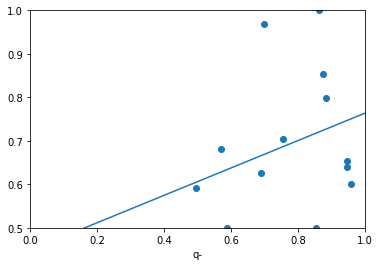

In [ ]:
xx = np.linspace(0, 1, 100)

plt.scatter(dados[:, i], target);
# plt.plot(xx, res.predict(xx))
plt.plot(xx, res.predict(sm.add_constant(xx)))
plt.xlabel('{}'.format(indices[i]))
plt.ylim([0.5, 1])
plt.xlim([0, 1]);

## plot

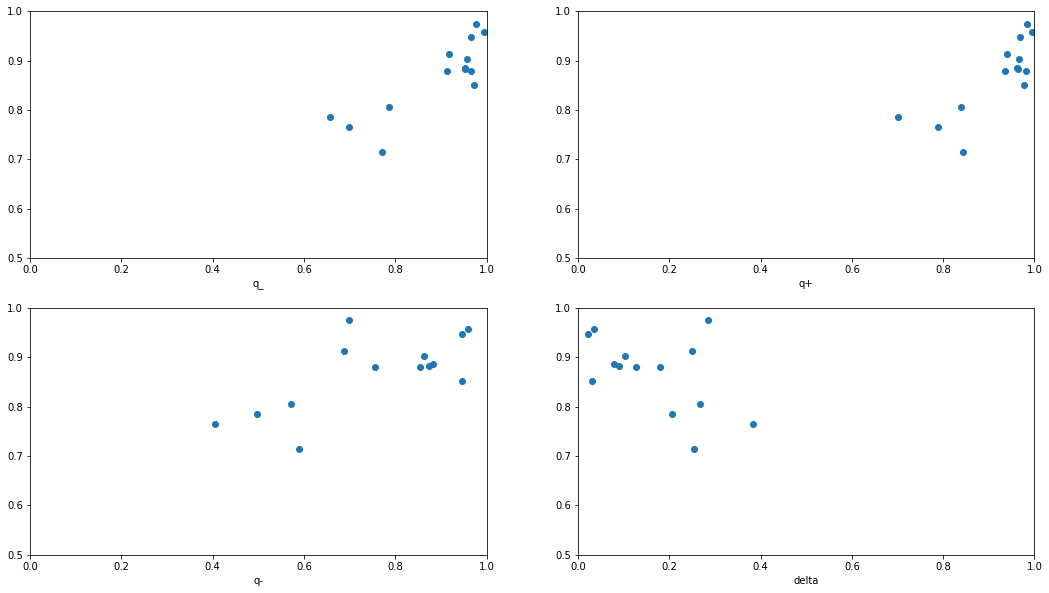

In [ ]:
fig, axis = plt.subplots(2, 2, figsize = (18, 10))

axis[0, 0].scatter(dados[:, 1], target);
axis[0, 0].set_xlabel('q_')
axis[0, 0].set_ylim([0.5, 1])
axis[0, 0].set_xlim([0, 1]);

axis[0, 1].scatter(dados[:, 2], target);
axis[0, 1].set_xlabel('q+')
axis[0, 1].set_ylim([0.5, 1])
axis[0, 1].set_xlim([0, 1]);

axis[1, 0].scatter(dados[:, 3], target);
axis[1, 0].set_xlabel('q-')
axis[1, 0].set_ylim([0.5, 1])
axis[1, 0].set_xlim([0, 1]);

axis[1, 1].scatter(dados[:, 2] - dados[:, 3], target);
axis[1, 1].set_xlabel('delta')
axis[1, 1].set_ylim([0.5, 1])
axis[1, 1].set_xlim([0, 1]);